# Modelling tabular data with diffusion models

This tutorial demonstrates hot to use a denoising diffusion probabilistic model (DDPM) to synthesize tabular data. The algorithm was proposed in [TabDDPM: Modelling Tabular Data with Diffusion Models](https://arxiv.org/abs/2209.15421).

In [1]:
# stdlib
import sys
import warnings

# third party
import numpy as np
from sklearn.datasets import load_iris, load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## Synthesize a classification dataset

For classification datasets, TabDDPM automatically uses the labels as the conditional variable during training. You should not provide an additional `cond` argument to the `fit` method.

In [2]:
# Note: preprocessing data with OneHotEncoder or StandardScaler is not needed or recommended. Synthcity handles feature encoding and standardization internally.

X, y = load_iris(return_X_y=True, as_frame=True)
X["target"] = y

loader = GenericDataLoader(X, target_column="target", sensitive_columns=[])

loader.dataframe().head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
y.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

### Model fitting

In [4]:
# define the model hyper-parameters
plugin_params = dict(
    is_classification = True,
    n_iter = 1000,  # epochs
    lr = 0.002,
    weight_decay = 1e-4,
    batch_size = 1000,
    model_type = "mlp",  # or "resnet"
    model_params = dict(
        n_layers_hidden = 3,
        n_units_hidden = 256,
        dropout = 0.0,
    ),
    num_timesteps = 500,  # timesteps in diffusion
    dim_embed = 128,
    # performance logging
    log_interval = 10,
    print_interval = 100,
)

plugin = Plugins().get("ddpm", **plugin_params)
plugin.fit(loader)

[2023-04-06T19:07:53.035827+0200][45392][INFO] Encoding sepal length (cm) 8461685668942494555
[2023-04-06T19:07:53.045457+0200][45392][INFO] Encoding sepal width (cm) 7372477013158199918
[2023-04-06T19:07:53.054429+0200][45392][INFO] Encoding petal length (cm) 8795408021141068254
[2023-04-06T19:07:53.066673+0200][45392][INFO] Encoding petal width (cm) 1839870727438321343
[2023-04-06T19:07:55.483186+0200][45392][INFO] Step 100: MLoss: 0.0 GLoss: 0.3032 Sum: 0.3032


In [5]:
plugin.model

TabDDPM(
  (diffusion): GaussianMultinomialDiffusion(
    (denoise_fn): DiffusionModel(
      (emb_nonlin): SiLU()
      (proj): Linear(in_features=4, out_features=128, bias=True)
      (time_emb): TimeStepEmbedding(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (label_emb): Embedding(3, 128)
      (model): MLP(
        (model): Sequential(
          (0): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=128, out_features=256, bias=True)
              (1): ReLU()
            )
          )
          (1): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
              (1): ReLU()
            )
          )
          (2): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=256, out_features=256, bia

<Axes: xlabel='step'>

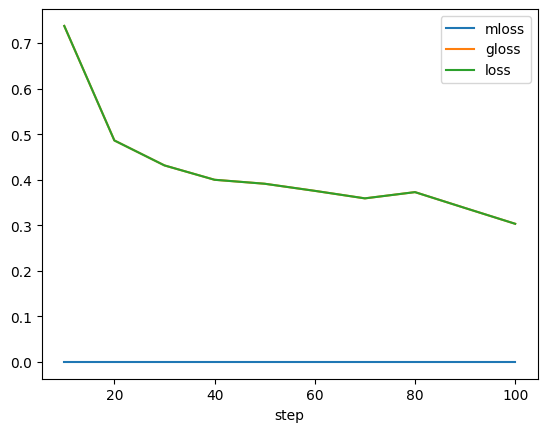

In [6]:
# plot training curves
plugin.loss_history.plot()

### Data generation

Since the model training is conditional to the labels, the data generation requires the labels as well. You can pass the labels as a `cond` argument to the `generate` method. If it is not provided, the model will randomly generate the labels following the multinomial distribution of the training labels.

In [7]:
plugin.generate(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.300000,4.400000,1.000000,0.100000,1
1,7.900000,4.400000,6.900000,2.500000,2
2,5.740312,2.060491,2.659118,0.982462,1
3,4.300000,2.000000,1.000000,0.100002,1
4,4.300000,2.000000,1.000000,0.100000,1
5,4.505079,2.025100,3.619546,0.208050,1
6,6.108867,2.511960,4.668570,1.392304,1
7,5.536599,2.549499,4.443977,1.345480,1
8,7.900000,4.400000,6.900000,2.500000,2
9,4.300000,2.000000,1.000000,0.100000,1


### Conditional data generation

In [8]:
labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
plugin.generate(len(labels), cond=labels)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,7.900000,4.400000,1.000000,2.459848,0
1,4.300000,4.400000,1.000000,0.100000,0
2,7.900000,4.400000,1.000000,0.100000,0
3,5.499909,2.023536,3.788866,1.262810,1
4,4.300000,2.000000,1.000000,0.100000,1
5,4.300000,2.000000,1.000000,0.197491,1
6,7.900000,4.400000,6.900000,2.500000,2
7,4.300000,4.400000,1.000000,0.100000,0
8,4.300000,2.000000,1.000001,0.142259,1


## Synthesize a regression dataset

For regression datasets, there is no conditional variable by default. The model learns the joint distribution of the whole dataset and generates new data points from it.

In [9]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")

loader = GenericDataLoader(df, target_column="quality", sensitive_columns=[])
loader.dataframe().describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [11]:
# define the model hyper-parameters
plugin_params.update(
    is_classification = False,
    n_iter = 500,  # epochs
    lr = 5e-4,
    weight_decay = 1e-4,
    batch_size = 1250,
    model_params = dict(
        n_layers_hidden = 3,
        n_units_hidden = 256,
        dropout = 0.0,
    ),
    num_timesteps = 100,  # timesteps in diffusion
)
plugin = Plugins().get("ddpm", **plugin_params)
plugin.fit(loader)

[2023-04-06T19:09:16.010623+0200][45392][INFO] Encoding fixed acidity 8821222230854998919
[2023-04-06T19:09:16.022381+0200][45392][INFO] Encoding volatile acidity 3689048099044143611
[2023-04-06T19:09:16.035202+0200][45392][INFO] Encoding citric acid 735380040632581265
[2023-04-06T19:09:16.046041+0200][45392][INFO] Encoding residual sugar 2442409671939919968
[2023-04-06T19:09:16.057037+0200][45392][INFO] Encoding chlorides 7195838597182208600
[2023-04-06T19:09:16.069198+0200][45392][INFO] Encoding free sulfur dioxide 3309873879720413309
[2023-04-06T19:09:16.079198+0200][45392][INFO] Encoding total sulfur dioxide 8059822526963442530
[2023-04-06T19:09:16.089218+0200][45392][INFO] Encoding density 3625281346475756911
[2023-04-06T19:09:16.100269+0200][45392][INFO] Encoding pH 4552002723230490789
[2023-04-06T19:09:16.108269+0200][45392][INFO] Encoding sulphates 4957484118723629481
[2023-04-06T19:09:16.118284+0200][45392][INFO] Encoding alcohol 3711001505059098944
[2023-04-06T19:09:16.128449

<Axes: xlabel='step'>

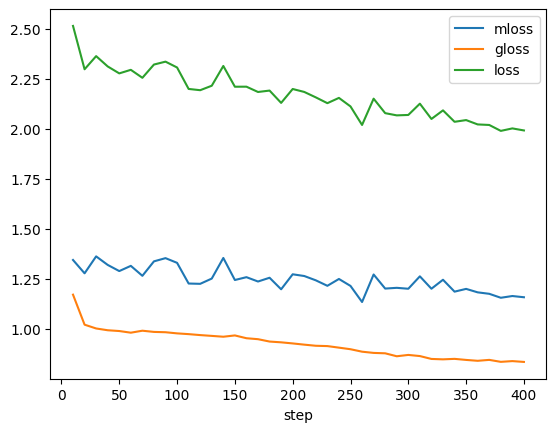

In [12]:
plugin.loss_history.plot()

In [13]:
plugin.generate(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,14.2,0.08,1.66,65.8,0.346,289.0,9.0,1.03898,2.720000,0.22,14.2,6
1,14.2,1.10,0.00,0.6,0.346,289.0,440.0,0.98711,2.720000,1.08,14.2,7
2,3.8,0.08,1.66,65.8,0.346,289.0,9.0,0.98711,3.820000,0.22,8.0,5
3,3.8,0.08,0.00,0.6,0.346,289.0,440.0,0.98711,2.720000,0.22,14.2,7
4,14.2,1.10,0.00,0.6,0.346,289.0,9.0,0.98711,3.771223,1.08,14.2,7
5,14.2,1.10,1.66,65.8,0.009,2.0,440.0,0.98711,2.720000,1.08,14.2,7
6,3.8,0.08,0.00,65.8,0.346,2.0,9.0,1.03898,2.720000,1.08,8.0,7
7,14.2,0.08,1.66,0.6,0.346,289.0,9.0,0.98711,3.820000,0.22,14.2,7


### Conditional data generation

A conditional variable `cond` can be provided to the `fit` method. It can be either a column name in the dataset or a custom array. The model will then learn the conditional distribution of the dataset given `cond`. In this case, an array must be provided as the `cond` argument of the `generate` method.

Use a column name as the `cond` argument in the `fit` method:

In [14]:
plugin.fit(loader, cond='quality')

[2023-04-06T19:10:28.307332+0200][45392][INFO] Encoding fixed acidity 8821222230854998919
[2023-04-06T19:10:28.316302+0200][45392][INFO] Encoding volatile acidity 3689048099044143611
[2023-04-06T19:10:28.328835+0200][45392][INFO] Encoding citric acid 735380040632581265
[2023-04-06T19:10:28.337818+0200][45392][INFO] Encoding residual sugar 2442409671939919968
[2023-04-06T19:10:28.346502+0200][45392][INFO] Encoding chlorides 7195838597182208600
[2023-04-06T19:10:28.355523+0200][45392][INFO] Encoding free sulfur dioxide 3309873879720413309
[2023-04-06T19:10:28.367907+0200][45392][INFO] Encoding total sulfur dioxide 8059822526963442530
[2023-04-06T19:10:28.379128+0200][45392][INFO] Encoding density 3625281346475756911
[2023-04-06T19:10:28.388190+0200][45392][INFO] Encoding pH 4552002723230490789
[2023-04-06T19:10:28.396086+0200][45392][INFO] Encoding sulphates 4957484118723629481
[2023-04-06T19:10:28.404089+0200][45392][INFO] Encoding alcohol 3711001505059098944
[2023-04-06T19:10:28.412665

<Axes: xlabel='step'>

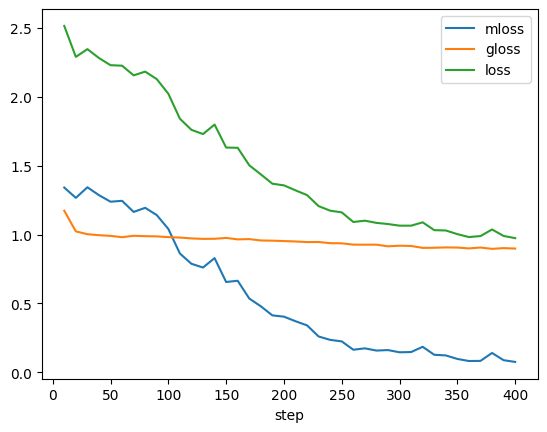

In [15]:
plugin.loss_history.plot()

In [16]:
outcome = np.array([3, 4, 5, 6, 7, 8, 9])
outcome

array([3, 4, 5, 6, 7, 8, 9])

In [17]:
plugin.generate(len(outcome), cond=outcome)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,14.2,0.08,1.66,0.6,0.346,289.0,9.0,0.98711,2.72,0.22,14.2,6
1,14.2,0.08,0.00,0.6,0.346,289.0,440.0,0.98711,2.72,1.08,14.2,8
2,3.8,0.08,1.66,65.8,0.346,289.0,9.0,0.98711,3.82,0.22,8.0,7
3,3.8,0.08,0.00,0.6,0.346,289.0,9.0,0.98711,2.72,0.22,14.2,5
4,14.2,1.10,1.66,0.6,0.346,289.0,440.0,1.03898,2.72,1.08,14.2,6
5,14.2,0.08,1.66,0.6,0.009,2.0,9.0,0.98711,2.72,1.08,8.0,6
6,3.8,1.10,1.66,65.8,0.009,289.0,440.0,1.03898,2.72,1.08,8.0,5


Use an array as the `cond` argument of the `fit` method:

In [22]:
import random
cond = random.choices(outcome, k=len(loader))
plugin.fit(loader, cond=cond)

[2023-04-06T19:23:00.914877+0200][45392][INFO] Encoding fixed acidity 8821222230854998919
[2023-04-06T19:23:00.923931+0200][45392][INFO] Encoding volatile acidity 3689048099044143611
[2023-04-06T19:23:00.934174+0200][45392][INFO] Encoding citric acid 735380040632581265
[2023-04-06T19:23:00.954557+0200][45392][INFO] Encoding residual sugar 2442409671939919968
[2023-04-06T19:23:00.965758+0200][45392][INFO] Encoding chlorides 7195838597182208600
[2023-04-06T19:23:00.976757+0200][45392][INFO] Encoding free sulfur dioxide 3309873879720413309
[2023-04-06T19:23:00.996365+0200][45392][INFO] Encoding total sulfur dioxide 8059822526963442530
[2023-04-06T19:23:01.005686+0200][45392][INFO] Encoding density 3625281346475756911
[2023-04-06T19:23:01.014352+0200][45392][INFO] Encoding pH 4552002723230490789
[2023-04-06T19:23:01.021350+0200][45392][INFO] Encoding sulphates 4957484118723629481
[2023-04-06T19:23:01.029350+0200][45392][INFO] Encoding alcohol 3711001505059098944
[2023-04-06T19:23:01.036351

<Axes: xlabel='step'>

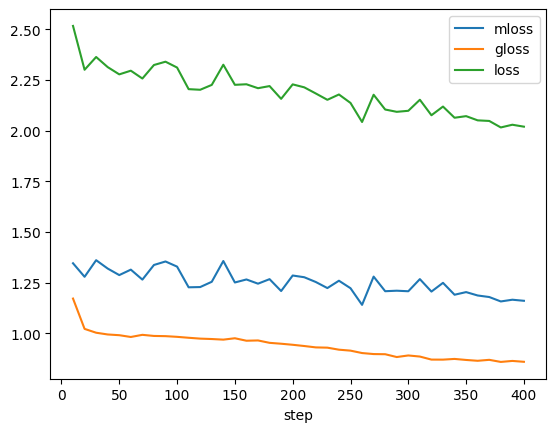

In [19]:
plugin.loss_history.plot()

In [21]:
plugin.generate(len(outcome), cond=outcome)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,3.8,0.08,0.00,0.6,0.346,2.0,440.0,1.03898,3.82,1.08,14.2,7
1,14.2,1.10,1.66,65.8,0.346,289.0,440.0,0.98711,3.82,0.22,8.0,5
2,3.8,1.10,1.66,65.8,0.346,289.0,440.0,0.98711,2.72,0.22,14.2,6
3,3.8,1.10,0.00,65.8,0.009,2.0,440.0,0.98711,2.72,1.08,8.0,7
4,3.8,1.10,1.66,65.8,0.009,289.0,9.0,0.98711,3.82,0.22,8.0,7
5,14.2,1.10,1.66,65.8,0.346,289.0,9.0,1.03898,2.72,0.22,14.2,7
6,3.8,1.10,1.66,65.8,0.009,2.0,440.0,0.98711,3.82,0.22,14.2,6


## Congratulations!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards Machine learning and AI for medicine, you can do so in the following ways!

### Star [Synthcity](https://github.com/vanderschaarlab/synthcity) on GitHub

- The easiest way to help our community is just by starring the Repos! This helps raise awareness of the tools we're building.


### Checkout other projects from vanderschaarlab
- [HyperImpute](https://github.com/vanderschaarlab/hyperimpute)
- [AutoPrognosis](https://github.com/vanderschaarlab/autoprognosis)
